# Cycle Life Prediction: Generalized Severson Analysis

This notebook generalizes the analysis presented in Severson's 2019 Nature Energy paper for cycle life prediction from the first 100 cycles of test data.

Through a series of widgets, users can select any number of Train and Test datasets from the Voltaiq Community server, featurize those datasets based on generalizations of the features in Severson et al, train and test the Severson Variance and/or Discharge models on the Train/Test datasets, evaluate model performance, and predict cycle life for any number of Prediction datasets of interest.

### Inputs:
- **Model(s):** Users can select which models they would like to evaluate. We currently offer comparisons between the Severson Variance, Severson Discharge and Dummy models, but will continue to add in additional models from the literature. We also plan to allow users to specify their own models in the future.
    - Once a model is selected, users can Train and Test their models, including showing parity plots, RMSE and MAPE performance plots for their selected model(s).
- **Featurization inputs:** The train and test data will be featurized based on the Severson models, with the following nuances:
    - Rather than using a hard-coded reference capacity for 80% capacity retention, we allow for a flexible capacity retention threshold based on the initial capacity of a test. Instead of choosing the first cycle to drop below the capacity retention threshold, we choose the first cycle to do so within a sequence of 5 consecutive cycles; this provides some robustness against noise/fluctuations
    - A user also inputs the `start` and `end` cycles for which to perform the differencing for the voltage vs capacity data. The default is cycles 9 and 99 to correspond with the Severson analysis (note that Voltaiq uses zero-indexing on cycles as a default, unless they are explicitly specified in an input file). Note that all tests within the Train and Test datasets must include these two cycles.
    - A cycle number must also be given from which to calculate reference capacity. The current script implementation allows a user to choose a cycle ordinal from which to calculate a reference capacity. The Severson model used cell nominal capacity as a reference capacity; however this is not known for each dataset on Voltaiq Community. Thus, a reference capacity based on the cycling data is chosen instead. Currently this cycle number must be the same for all datasets used for the model. A fixed reference cycle choice requires a user to have some information about what cycle to choose – the default ordinal is cycle 20 as that works for the curated datasets provided with this script.
    - Voltage vs capacity data is still interpolated between the min and max values for each test record; note that the features based on a specific voltage cutoff are no longer applicable
- **Train dataset:** Data which will be used to train the ML model(s) you choose. Choose from a number of curated publicly-available datasets, and/or choose custom data based on a test name search criteria
    - Tests must include the same `start` and `end` cycle for the analysis range and tests should also obtain the expected end capacity retention %. If tests do not contain the `start` and `end`cycles, the code will throw an error. If tests do not meet the expected capacity retention %, those tests will be excluded from the Train and Test featurization and model evaluation.
    - We provide an option for filtering data based on a minimum cycle count, as well as the set capacity retention threshold. Filtering by capacity retention threshold can be slow, so should be used in conjunction with a cycle number and/or test name filter.
- **Test dataset:** Data which will be used to test (evaluate the performance) of the ML model(s) you choose. You may either choose to perform a train-test split (with a configurable split ratio) on the Train dataset, or manually choose data in a manner similar to how you chose the Train dataset.
- **Prediction dataset:** After a model is trained and evaluated on the test dataset, users can select a Prediction dataset, and use the ML model(s) of their choice to predict the cycle life of this new dataset. Again, users can select from a curated list or choose a custom dataset based on a test name search criteria.
    

### Outputs:
- Train/Test parity plots, RMSE, MAPE performance plots
- The prediction step will generate a bar chart comparing the predicted cycle life for each model for each test record within the dataset, as well as the current (last) cycle of that test record
- All train/test results can be accessed through methods and attributes of the CL_prediction class. Further exploration of the data results is possible using the resulting dataframes.

### Recommended datasets:
The Severson models were developed on fast-charge LFP cycling data. The Variance model contains a single feature based on the variance of the difference between voltage vs capacity curves of two cycles (`start` and `end`). It is likely that these ML models are degradation mode specific. Since the expected degradation mode of the original dataset focused on loss of active material of the negative electrode, cells which have that degradation mode might show better fits. Additionally, it is recommended that similar discharge protocols and cut-off voltages are used for comparison/calculate purposes for the datasets. This is because the features are calculated based on discharge steps, and data is interpolated between the upper and lower cutoff voltages. Significantly different cycling protocols might not allow the ML model to capture the appropriate feature signatures.

#### References: 
[Schauser Nicole S., Lininger Christianna N., Leland Eli S., Sholklapper Tal Z. An open access tool for exploring machine learning model choice for battery life cycle prediction. Frontiers in Energy Research, 10 (2022) DOI: 10.3389/fenrg.2022.1058999](https://www.frontiersin.org/articles/10.3389/fenrg.2022.1058999)

[Severson et al. Data-driven prediction of battery cycle life before capacity degradation. Nature Energy volume 4, pages 383–391 (2019)](https://www.nature.com/articles/s41560-019-0356-8)


### Model uncertainty / prediction intervals
It is important to not only be able to look at a model's error during the training process, but also be able to estimate or identify the model uncertainty for a new prediction. This can be identified for every new prediction using a model's prediction interval.

There are a few ways to obtain the prediction intervals. For linear regression, these can be computed analytically. For other models, they are inherently included in the model framework (e.g. Bayesian approaches such as [Bayesian Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html), [Gaussian Process Regression](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html) and [Gradient Boosting Regression](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html)). Lastly, there are options for computing the prediction uncertainty using python packages such as [MAPIE](https://github.com/scikit-learn-contrib/MAPIE), which stands for "Model Agnostic Prediction Interval Estimator". A good tutorial on using MAPIE for tabular regression (as is the case for cycle life prediciton) can be found in their [documentation](https://mapie.readthedocs.io/en/latest/examples_regression/4-tutorials/plot_main-tutorial-regression.html). The benefits of this approach is that it can be used for any sklearn-compatible regressor, making it a powerful option when trying to compare multiple models!

The MAPIE output provides both the prediction value obtained by a model (i.e. the cycle life predicted by a model for a specific input cell), as well as a prediction interval given by a lower and upper bound. This prediction interval provides the bounds for the expected error or noise on the prediction, such that the 'true' value is expected to fall within the prediction interval with `(100-alpha)`% coverage (that is, in `(100-alpha)`% of the cases, we expect the 'true' value to fall within this interval). Note that `alpha` is a tunable parameter but is most commonly taken as `5`, such that we have a 95% prediction interval. Additional documentation on the implementation (in our cse we have chosen the CV+ method) can be found in the [documentation](https://mapie.readthedocs.io/en/latest/theoretical_description_regression.html), which also references the original publications.

For more information on error estimation, see [this tutorial](https://www.voltaiqcommunity.com/editions/studio?showcase=9f5362af-1590-47d9-9554-b645201cc809) we have created.

We have augmented this script (after the Frontiers in Energy Research 2022 publication) to include prediction intervals for both the Train/Test data (which can be accessed from the parity plots as well as from dataframes), and for prediction data. Initial inspiration was taken from this [blog post](https://www.valencekjell.com/posts/2022-09-14-prediction-intervals/)

#### Imports and set-up

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mapie

Note: you may need to restart the kernel to use updated packages.


In [1]:
import voltaiq_studio as vs
from voltaiq_studio import TraceFilterOperation

import severson_featurization
import ML_models
import cl_widgets as cpw
import importlib
# importlib.reload(CL_prediction)
importlib.reload(ML_models)
importlib.reload(severson_featurization)
importlib.reload(cpw)
from CL_prediction import CLPrediction
from severson_featurization import calc_X_and_y, drop_unfinished_tests

import ipywidgets as widgets
from ipywidgets import interactive, interact, fixed

from IPython.display import display, Markdown

import pickle
from datetime import datetime

import numpy as np
import pandas as pd
from scipy import stats
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
import seaborn as sns

# set a few default figure parameters
mpl.rcParams['figure.figsize'] = (3,3)
colors = ['#332288','#882255','#117733','#AA4499','#44AA99','#CC6677','#88CCEE','#DDCC77','#A3E8E7']

mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)
fontsize = 6
titlesize = 8
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['legend.fontsize'] = fontsize
mpl.rcParams['figure.titlesize'] = titlesize
mpl.rcParams['axes.labelsize']=fontsize
mpl.rcParams['lines.markersize'] = fontsize
mpl.rcParams['figure.dpi'] = 150

In [2]:
trs = vs.get_test_records()

### User inputs: Select Model(s), Model Inputs, Train data and Test data

In [3]:
# we will start by instantiating a cycle life prediction object 
# which will store all relevant information for the datasets and models you will choose
prediction1 = CLPrediction()

#### Select Models

In [4]:
model_options = ['All','Dummy','Severson variance','Severson discharge','Severson discharge XGBoost']

In [5]:
choose_model = interactive(cpw.set_model, model_choice = widgets.SelectMultiple(options = model_options, value=['All'], description='Choose ML model(s)',style={'description_width': 'initial'},disabled=False), prediction_object = fixed(prediction1), model_options = fixed(model_options))
display(choose_model)

interactive(children=(SelectMultiple(description='Choose ML model(s)', index=(0,), options=('All', 'Dummy', 'S…

#### Select Featurization Criteria

In [6]:
featurize = interactive(cpw.featurize_inputs_widget, start_cycle = widgets.IntText(value = 20, description = 'Initial cycle: ', disabled=False,continuous_update = False),
                        end_cycle = widgets.IntText(value = 99, description = 'End cycle: ', disabled=False,continuous_update = False),
                        per_cap_ret = widgets.BoundedFloatText(value = 85,min = 0, max = 100, step = 1, description = '% Capacity Retention:',style={'description_width': 'initial'}, disabled=False,continuous_update = False),
                       prediction1 = fixed(prediction1),ref_cyc = widgets.BoundedFloatText(value = 20, min = 0, step = 1, description = "Reference cycle for capacity normalization",style={'description_width': 'initial'} ))
display(featurize)

interactive(children=(IntText(value=20, description='Initial cycle: '), IntText(value=99, description='End cyc…

#### Select Training Dataset

In [35]:
display(Markdown("#### Search for test records to add to Train dataset"))
display(Markdown("To use MAPIE error estimation, must have at least 20 Train and 20 Test cells"))
display(Markdown("Filtering tests by capacity retention is slow; check kernel status for update on completion."))
# search_type = widgets.RadioButtons(options=['Test Name','Min Cycle Number','Both'],
#                                     disabled=False)
# Want to add in some search criteria here: min cycle number (if blank, ignore), min capacity retention

select_train = interactive(cpw.select_widget, 
                           train_sets = widgets.SelectMultiple(value=[], options=cpw.std_train_datasets, description=f'Training Datasets:',style={'description_width': 'initial'}, ensure_option=True),
                          train_or_test=fixed('train'), pred_obj = fixed(prediction1), trs = fixed(trs), predict_button = fixed(None))

display(select_train)

#### Search for test records to add to Train dataset

To use MAPIE error estimation, must have at least 20 Train and 20 Test cells

Filtering tests by capacity retention is slow; check kernel status for update on completion.

interactive(children=(SelectMultiple(description='Training Datasets:', options=('Severson2019 - All (LFP)', 'S…

#### Select Testing Dataset (or train-test-split ratio)

In [8]:
test_select_dropdown = interactive(cpw.test_select_method,method = widgets.Dropdown(options = ['Use train_test_split on training dataset','Select test dataset manually'], 
                                                                                value = None, description = 'Test dataset selection method', style={'description_width': 'initial'},
                                                                                layout = widgets.Layout(width='500px')), prediction1 = fixed(prediction1), trs = fixed(trs),predict_button=fixed(None))
display(test_select_dropdown)

interactive(children=(Dropdown(description='Test dataset selection method', layout=Layout(width='500px'), opti…

#### Featurize the data

In [9]:
output = widgets.Output()
perform_featurize = widgets.Button(description = 'Featurize data', button_style = 'danger', style={"button_color": "#38adad"})

display(perform_featurize, output)

def featurize(b):
    ''' function that will featurize the data'''
    with output:
        cpw.populate_test_train_data(prediction1, trs)
        print("Starting featurization...")
        prediction1.featurize(trs)
        print("Featurization complete!")

perform_featurize.on_click(featurize)

Button(button_style='danger', description='Featurize data', style=ButtonStyle(button_color='#38adad'))

Output()

#### Train & Test ML model(s)

In [34]:
mapie_error_disabled = (len(prediction1.X_train) < 20) and (len(prediction1.X_test) < 20)
mapie_error_checkbox = widgets.Checkbox(value=not(mapie_error_disabled),description='Include MAPIE error estimation',style={'description_width': 'initial'},disabled=mapie_error_disabled)
train_model_button = widgets.Button(description = 'Train model', button_style = 'danger', style={"button_color": "#38adad"})
test_button = widgets.Button(description = 'Test model', button_style = 'danger', style={"button_color": "#38adad"},disabled=True,)
parity_button = widgets.Button(description = 'Generate Parity Plots', button_style = 'danger', style={"button_color": "#38adad"},disabled=True)
MAPE_button = widgets.Button(description = 'Plot MAPE results', button_style = 'danger', style={"button_color": "#38adad"},disabled=True)
RMSE_button = widgets.Button(description = 'Plot RMSE results', button_style = 'danger', style={"button_color": "#38adad"},disabled=True)


output = widgets.Output()
display(mapie_error_checkbox,train_model_button, test_button,parity_button,MAPE_button,RMSE_button, output)

def train_button(b):
    with output:
        prediction1.train_model(mapie_error_checkbox.value)
        test_button.disabled = False

def test_click(b):
    with output:
        prediction1.test_predict()
        parity_button.disabled = False
        MAPE_button.disabled = False
        RMSE_button.disabled = False
        
def parity_click(b):
    with output:
        prediction1.create_parity_plots()

def mape_click(b):
    with output:
        prediction1.plot_model_stats('MAPE')
        prediction1.plot_grouped_model_stats('MAPE')
        
def rmse_click(b):
    with output:
        prediction1.plot_model_stats('RMSE')
        
train_model_button.on_click(train_button)
test_button.on_click(test_click)
parity_button.on_click(parity_click)
MAPE_button.on_click(mape_click)
RMSE_button.on_click(rmse_click)

Checkbox(value=True, description='Include MAPIE error estimation', style=DescriptionStyle(description_width='i…

Button(button_style='danger', description='Train model', style=ButtonStyle(button_color='#38adad'))

Button(button_style='danger', description='Test model', disabled=True, style=ButtonStyle(button_color='#38adad…

Button(button_style='danger', description='Generate Parity Plots', disabled=True, style=ButtonStyle(button_col…

Button(button_style='danger', description='Plot MAPE results', disabled=True, style=ButtonStyle(button_color='…

Button(button_style='danger', description='Plot RMSE results', disabled=True, style=ButtonStyle(button_color='…

Output()

#### Saving a model for future use
The next section allows a user to save a trained model for use on predicitons in the future. Users must select the model(s) they would like to save, as well as names for those models. Models will be saved as pickle files which can be loaded back into python for futher use.

In [11]:
# save the entire prediction object. This includes all models and formatted data
name = "prediction_example" + str(datetime.now())
with open(name,'wb') as files:
    pickle.dump(prediction1, files)

In [12]:
# just save the models
for model in prediction1.ml_model:
    print(model)

Dummy
Severson variance
Severson discharge
Severson discharge XGBoost


In [13]:
# choose a model from the list and edit the model_to_save variable
model_to_save = 'Severson variance'
model_name = model_to_save + str(datetime.now())
with open(model_name,'wb') as files:
    pickle.dump(prediction1.trained_models[model_to_save], files)

In [14]:
# just save the featurized data:
X_train, X_test, y_train, y_test = prediction1.get_featurized_data()
data_dict = {'X_train':X_train,' X_test':X_test, 'y_train':y_train, 'y_test':y_test}
data_name = "prediction_data" + str(datetime.now())
with open(data_name,'wb') as files:
    pickle.dump(data_dict, files)

To load in a prediction object, use the following code block:

In [15]:
load_name = name
with open(load_name, "rb") as f:
    prediction_load = pickle.load(f)

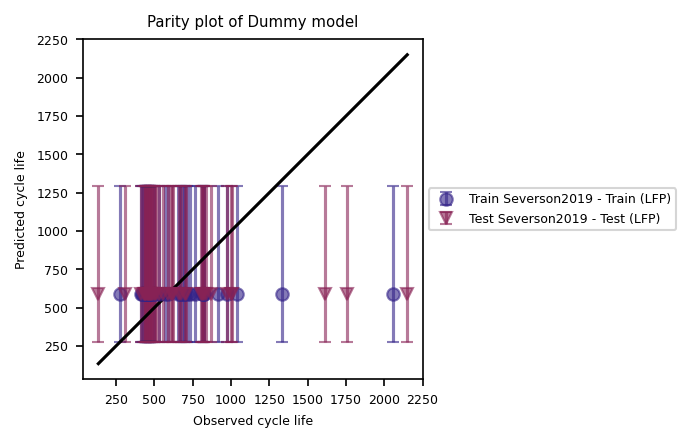

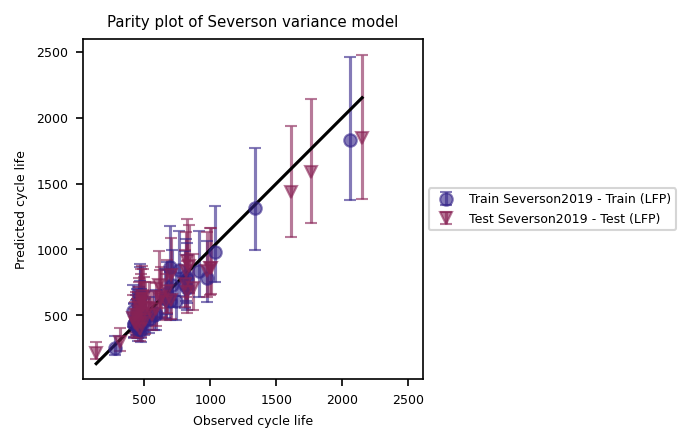

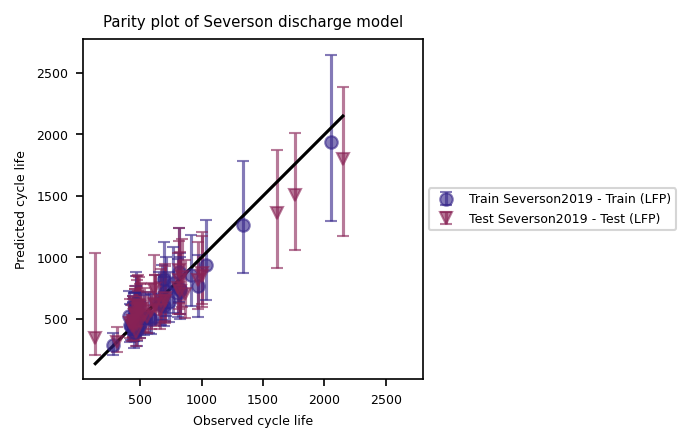

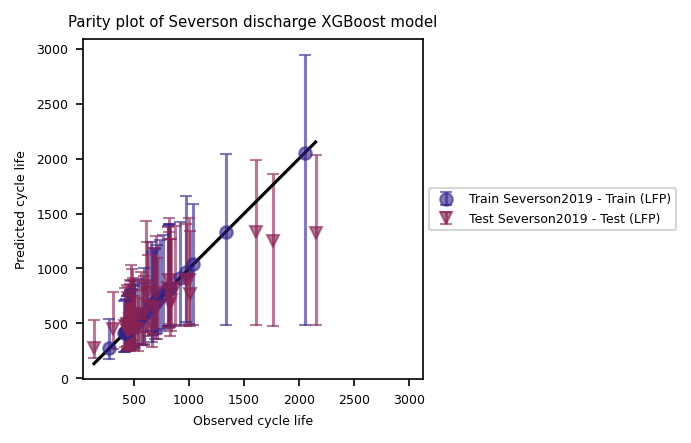

In [16]:
# we can examine the prediction object by creating the parity plots, for example
prediction_load.create_parity_plots()

Similar code can be used for models or data:

In [17]:
load_name = model_name
with open(load_name, "rb") as f:
    model_load = pickle.load(f)

In [18]:
load_name = data_name
with open(load_name, "rb") as f:
    data_load = pickle.load(f)
data_load['X_train'].head()

,min_deltaQ,mean_deltaQ,var_deltaQ,skew_deltaQ,kur_deltaQ,deltaQ_lowV,slope_22_99,intcpt_22_99,slope_90_99,intcpt_90_99,q_22,maxQ_q_22,q_99,Name,Dataset_group
0,-2.070144,-2.455492,-5.028018,-0.427786,-1.869674,-0.002186,-0.000017,1.082534,-0.000029,1.083580,1.081923,0.608978,1.080649,2017-05-12_3_6C-80per_3_6C_CH2_VDF,Severson2019 - Train (LFP)
1,-1.840401,-2.218537,-4.632537,-0.526915,0.097271,-0.002521,-0.000007,1.085825,-0.000007,1.085408,1.085078,0.007000,1.084765,2017-05-12_4C-80per_4C_CH5_VDF,Severson2019 - Train (LFP)
2,-1.657452,-2.032932,-4.293405,-0.725104,0.064739,-0.004419,-0.000011,1.081323,-0.000024,1.082180,1.080456,0.001615,1.079788,2017-05-12_4_4C-80per_4_4C_CH7_VDF,Severson2019 - Train (LFP)
3,-1.547026,-1.950946,-4.041558,-0.335869,0.064054,-0.003491,-0.000024,1.098508,-0.000033,1.099141,1.096267,0.001701,1.095874,2017-05-12_4_8C-80per_4_8C_CH9_VDF,Severson2019 - Train (LFP)
4,-1.589375,-2.030320,-4.108288,-0.228045,0.051376,-0.003403,-0.000008,1.061089,-0.000014,1.061318,1.060326,0.002914,1.059947,2017-05-12_5_4C-50per_3C_CH14_VDF,Severson2019 - Train (LFP)


With the next block of code, a user can set the loaded model to be the model used for analysis moving forward:

In [19]:
prediction1 = prediction_load

#### Exploring data feature distributions

First, identify the most important features for the Severson Discharge model (skip this step if the model was not chosen).

Next, plot the feature distributions of the three most important features in terms of model weighting.

In [20]:
eNet_dchg_coef = pd.DataFrame()
eNet_dchg_coef['features'] = prediction1.trained_models['Severson discharge'].pipeline.named_steps['enet'].coef_
eNet_dchg_coef['coef'] = prediction1.trained_models['Severson discharge'].X_train.columns
eNet_dchg_coef['abs_features'] = abs(eNet_dchg_coef['features'])
eNet_dchg_coef_sorted = eNet_dchg_coef.sort_values('abs_features',ascending=False)
eNet_dchg_coef_sorted.reset_index(inplace=True,drop=True)
eNet_dchg_coef_sorted.drop(columns=['abs_features'],inplace=True)

eNet_dchg_coef_sorted

,features,coef
0,-0.087075,mean_deltaQ
1,-0.058671,var_deltaQ
2,0.017622,intcpt_22_99
3,-0.010282,slope_22_99
4,-0.006508,kur_deltaQ
5,-0.000000,min_deltaQ
6,0.000000,skew_deltaQ
7,0.000000,deltaQ_lowV
8,-0.000000,slope_90_99
9,0.000000,intcpt_90_99


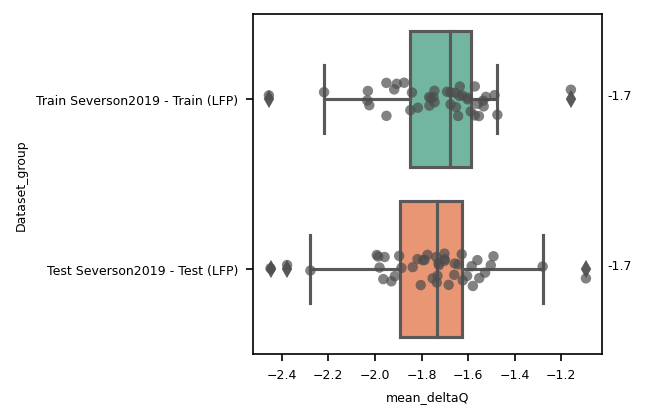

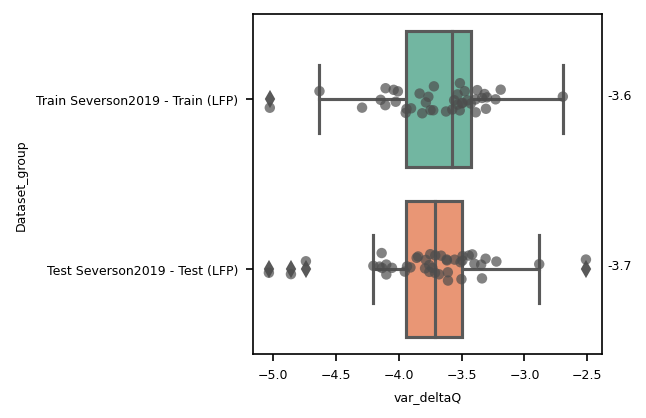

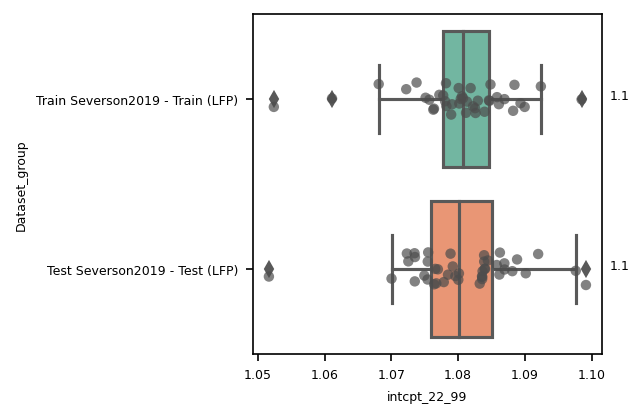

In [21]:
for feature in eNet_dchg_coef_sorted.coef[0:3]:
    prediction1.grouped_feature_distribution(feature)

#### Pearson correlation coefficient plots and analysis

In [22]:
train_test_variance_grp = pd.concat([prediction1.X_train[['Dataset_group','var_deltaQ']],prediction1.X_test[['Dataset_group','var_deltaQ']]],ignore_index=True)
train_test_log_cyc = pd.concat([prediction1.y_train[['log_cyc_life']],prediction1.y_test[['log_cyc_life']]],ignore_index=True)

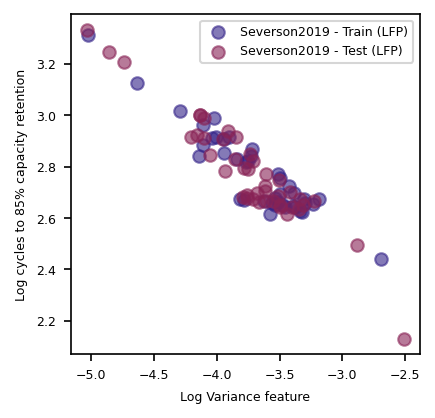

In [23]:
unique_grps = pd.unique(train_test_variance_grp.Dataset_group)

for grp in unique_grps:
    train_idx = train_test_variance_grp[train_test_variance_grp.Dataset_group == grp].index
    plt.scatter(x=train_test_variance_grp.var_deltaQ[train_idx],y=train_test_log_cyc.log_cyc_life[train_idx],label=grp,alpha=0.6)
# plt.yscale('log')
plt.legend(loc='best',bbox_to_anchor=(1,1))
# plt.axis('square')
plt.ylabel('Log cycles to 85% capacity retention')
plt.xlabel('Log Variance feature')
plt.show()

In [24]:
pearson_correlation = pd.DataFrame()
names = []
correlation = []
for grp in unique_grps:
    train_idx = train_test_variance_grp[train_test_variance_grp.Dataset_group == grp].index
    var = train_test_variance_grp.var_deltaQ[train_idx]
    lftm = train_test_log_cyc.log_cyc_life[train_idx]
    names.append(grp)
    correlation.append(stats.pearsonr(var, lftm)[0])
pearson_correlation['Dataset']=names
pearson_correlation['Pearson Correlation Coefficient'] = correlation
pearson_correlation

,Dataset,Pearson Correlation Coefficient
0,Severson2019 - Train (LFP),-0.930378
1,Severson2019 - Test (LFP),-0.950874


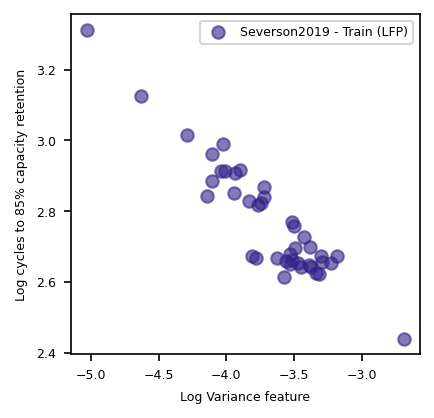

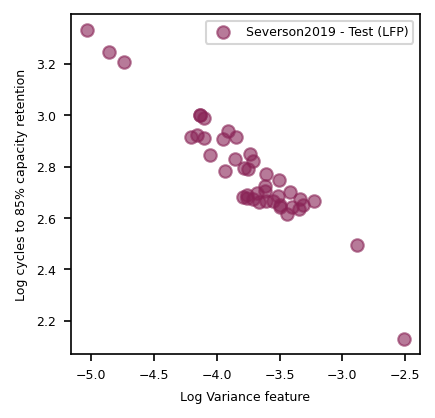

In [25]:
i=0
colors = colors*math.ceil(len(unique_grps)/len(colors))
for grp in unique_grps:
    train_idx = train_test_variance_grp[train_test_variance_grp.Dataset_group == grp].index
    plt.scatter(x=train_test_variance_grp.var_deltaQ[train_idx],y=train_test_log_cyc.log_cyc_life[train_idx],label=grp,alpha=0.6,c=colors[i])
    plt.legend()
    plt.ylabel('Log cycles to 85% capacity retention')
    plt.xlabel('Log Variance feature')
    plt.show()
    i+=1

#### Tabular data
The following code sections allow users to look at tabular data of the Test and Train dataset performance. Users will have to change the model and train_vs_test to update the dataframe that is returned. Note that the error columns provide information for error bars, and thus provide the [lower, upper] error (rather than lower, upper values) for each model type.

In [26]:
train_vs_test = "train"

prediction1.return_prediction_dataframes(train_vs_test)

,Name,Dummy Predicted CL error,Dummy Predicted cycle life,Severson variance Predicted CL error,Severson variance Predicted cycle life,Severson discharge Predicted CL error,Severson discharge Predicted cycle life,Severson discharge XGBoost Predicted CL error,Severson discharge XGBoost Predicted cycle life,Actual cycle life
0,2017-05-12_3_6C-80per_3_6C_CH2_VDF,"[316.6814622583038, 699.5331942660483]",591.681462,"[459.92644888311065, 628.8371674385455]",1831.526479,"[642.0565286802596, 712.5563075267357]",1935.981365,"[1561.6655915707283, 893.7935724457598]",2049.274902,2055.0
1,2017-05-12_4C-80per_4C_CH5_VDF,"[316.6814622583038, 699.5331942660483]",591.681462,"[312.0040027754087, 454.986805103503]",1311.373091,"[396.1402750938074, 520.6227868608757]",1265.734012,"[850.651717950286, 702.614729675116]",1336.166870,1336.0
2,2017-05-12_4_4C-80per_4_4C_CH7_VDF,"[316.6814622583038, 699.5331942660483]",591.681462,"[232.55455426588276, 344.7113947115731]",984.717083,"[285.22665294056355, 362.557752559694]",938.170719,"[551.5669082194364, 545.7807168520364]",1037.141235,1037.0
3,2017-05-12_4_8C-80per_4_8C_CH9_VDF,"[316.6814622583038, 699.5331942660483]",591.681462,"[186.94751835597856, 280.49248202172055]",796.009690,"[247.7110750157642, 361.9795896468578]",880.307706,"[335.9594185840185, 580.8712712003226]",817.490112,817.0
4,2017-05-12_5_4C-50per_3C_CH14_VDF,"[316.6814622583038, 699.5331942660483]",591.681462,"[198.08022043572475, 296.24139126290856]",842.168433,"[247.3466033602532, 295.08454484264405]",792.616757,"[318.76008502829785, 541.6662378636715]",766.474365,766.0
5,2017-05-12_5_4C-60per_3C_CH16_VDF,"[316.6814622583038, 699.5331942660483]",591.681462,"[204.56519060283824, 305.39258464690465]",869.026918,"[240.50748233210368, 296.44870880172346]",825.203016,"[287.72715636597917, 492.98415754920666]",693.962524,694.0
6,2017-05-12_5_4C-60per_3_6C_CH24_VDF,"[316.6814622583038, 699.5331942660483]",591.681462,"[181.5923432858358, 272.89840181440445]",773.781972,"[207.42756804564533, 291.5996972937171]",744.723451,"[340.91478014486853, 582.093330229699]",821.192871,821.0
7,2017-05-12_5_4C-70per_3C_CH18_VDF,"[316.6814622583038, 699.5331942660483]",591.681462,"[141.60729110896932, 215.7734201056868]",607.265069,"[168.62195029406257, 244.18283929028303]",640.557350,"[306.04938422563356, 521.8870022352048]",736.857849,736.0
8,2017-05-12_5_4C-80per_5_4C_CH12_VDF,"[316.6814622583038, 699.5331942660483]",591.681462,"[109.7450956753284, 169.6134608007158]",473.742034,"[132.2171626133255, 190.1390447609847]",504.336753,"[220.57482817938865, 377.13551948807446]",531.587463,532.0
9,2017-05-12_6C-40per_3C_CH25_VDF,"[316.6814622583038, 699.5331942660483]",591.681462,"[184.31808492808773, 276.76525799298076]",785.097697,"[249.71077185882723, 254.58372120231456]",763.578641,"[455.16104027583674, 688.5910710873131]",970.410339,974.0


#### Select Prediction dataset, and predict cycle lives

In [27]:
# next step is to allow users to select data for prediction. That needs to be featurized (but no y-values) and then the CL values can be predicted and shared (how to visualize...?)

predict_model_predict = widgets.Button(description = 'Predict Lifetime', button_style = 'danger', style={"button_color": "#38adad"}, disabled = True)

display(Markdown("#### Search for test records to add to Prediction dataset"))
display(Markdown("Filtering tests by capacity retention is slow; check kernel status for update on completion."))
# search_type = widgets.RadioButtons(options=['Test Name','Min Cycle Number','Both'],
#                                     disabled=False)
# Want to add in some search criteria here: min cycle number (if blank, ignore), min capacity retention

select_predict = interactive(cpw.select_widget, 
                           train_sets = widgets.SelectMultiple(value=[], options=cpw.std_train_datasets, description=f'Prediction Datasets:',style={'description_width': 'initial'}, ensure_option=True),
                          train_or_test=fixed('predict'), pred_obj = fixed(prediction1), trs = fixed(trs), predict_button = fixed(predict_model_predict))

# interactive(cpw.custom_select, filter_by_cap_retention = widgets.Checkbox(value=False,description='Filter tests by capacity retention threshold',
#                                                                                          style={'description_width': 'initial'}),
#                            min_cyc_num = widgets.IntText(description = 'Minimum # of cycles:',style={'description_width': 'initial'}, value = prediction1.get_end_cycle()+1),
#                            other_search_text = widgets.Text(
#                 value = prediction1.get_last_custom_search(),description='Test name search:', 
#                 style={'description_width': 'initial'},continuous_update=False),
#                                      train_or_test=fixed('predict'), prediction1 = fixed(prediction1),
#                                      trs = fixed(trs),predict_button = fixed(predict_model_predict))

output = widgets.Output()

display(select_predict,predict_model_predict, output)
    
        
def pred_model_predict(b):
    ''' function that will predict CL on prediction data. returns a plot of predicted cycle life'''
    with output:
        cpw.populate_test_train_data(prediction1, trs, predict = True)
        print("Starting featurization...")
        prediction1.featurize_predict(trs)
        print("Featurization complete!")
        prediction1.predict()
        prediction1.calc_predicted_cyclelife()
        if prediction1.get_use_mapie():
            prediction_df, predictiondf_errors, time_pred_df = prediction1.return_predicted_cyclelife()
            # append zeros for the errors associated with current cycle and cycle to 85% capacity
            predictiondf_errors.append([np.array([0]*len(prediction_df))]*2)
            predictiondf_errors.append([np.array([0]*len(prediction_df))]*2)
        else:
            prediction_df, time_pred_df = prediction1.return_predicted_cyclelife()
        log_scale = max(prediction_df.drop(columns = ['Name','Current cycle']).max()) > 10*(max(prediction_df['Current cycle']))
        if prediction1.get_use_mapie():
            prediction_df.set_index('Name').plot.barh(xerr = predictiondf_errors, capsize = 3,figsize=(10, len(prediction_df)/1.2), width = .8, logx = log_scale)
        else:
            prediction_df.set_index('Name').plot.barh(figsize=(10, len(prediction_df)/1.2), width = .8, logx = log_scale)

        plt.xlabel('Cycles')
        plt.title("Predicted cycle life by ML model for each test")
        plt.show()
        
        # want to only show predicted time to failure for tests that have not already 'failed'
        # so I want to add a filter criteria based on prediction_df
        if len(time_pred_df) >0:
            print("Predicted time remaining (hours) based on each ML model for tests which have not yet reached the capacity retention threshold")
            log_scale_time = max(time_pred_df.drop(columns = ['Name']).max()) > 10*(min(time_pred_df[time_pred_df.drop(columns = ['Name']) > 0].drop(columns = ['Name']).min()))

            time_pred_df.set_index('Name').plot.barh(figsize=(10, len(time_pred_df)/1.2),width = .8, logx = log_scale_time)
            plt.xlabel('Predicted Hours until Failure')
    #         plt.title
            plt.show()
        else:
            print("All tests in the Prediction dataset have already reached the set capacity retention threshold")

predict_model_predict.on_click(pred_model_predict)


#### Search for test records to add to Prediction dataset

Filtering tests by capacity retention is slow; check kernel status for update on completion.

interactive(children=(SelectMultiple(description='Prediction Datasets:', options=('Severson2019 - All (LFP)', …

Button(button_style='danger', description='Predict Lifetime', disabled=True, style=ButtonStyle(button_color='#…

Output()

To show the prediction dataframe including errors, run the following command. Note this only works if the MAPIE error estimation was enabled during model Training:

In [28]:
if prediction1.get_use_mapie():
    pred_df_with_error = prediction1.get_predicted_cyclelife_with_error()
    display(pred_df_with_error)

,Current cycle,Cycle to 85.0% capacity retention,Dummy Predicted Cycle Life,Dummy Predicted Cycle Life error,Severson discharge Predicted Cycle Life,Severson discharge Predicted Cycle Life error,Severson discharge XGBoost Predicted Cycle Life,Severson discharge XGBoost Predicted Cycle Life error,Severson variance Predicted Cycle Life,Severson variance Predicted Cycle Life error
Name,,,,,,,,,,
Cell_Expansion_21_cycling_wExpansion,338,0,591.681462,"[316.6814622583038, 699.5331942660483]",1.065108e+06,"[994558.0725665299, 4.979919475717736e+77]",287.189453,"[87.39023261049644, 309.65301940908716]",165.692913,"[38.776494851247364, 61.23202025448231]"
Cell_Expansion_20_cycling_wExpansion,560,0,591.681462,"[316.6814622583038, 699.5331942660483]",4.720230e+05,"[433882.96313096886, 53643941.28241422]",320.539490,"[117.86109563582613, 279.63573206714716]",90.676575,"[22.605493218867352, 34.480858789539155]"
Cell_Expansion_19_cycling_wExpansion,451,0,591.681462,"[316.6814622583038, 699.5331942660483]",7.839758e+05,"[715139.6262980738, 88323025.86970001]",289.796478,"[88.84631510971161, 304.7796656538592]",177.676108,"[41.263037217858624, 65.52381525281604]"
Cell_Expansion_18_cycling_wExpansion,296,0,591.681462,"[316.6814622583038, 699.5331942660483]",5.676912e+04,"[55359.88685498783, 3099503.154844224]",291.897400,"[93.0735283027266, 285.09460915494765]",268.179399,"[61.180230347592754, 97.68646029516555]"
Cell_Expansion_17_cycling_wExpansion,558,0,591.681462,"[316.6814622583038, 699.5331942660483]",2.690926e+05,"[218407.94033167348, 39482074.19913084]",292.253052,"[93.28472206497995, 327.3101234424015]",207.603373,"[47.382212767392616, 76.20493558235137]"
Cell_Expansion_16_cycling_wExpansion,533,0,591.681462,"[316.6814622583038, 699.5331942660483]",3.087976e+06,"[2822389.0869426196, 340327676.56289965]",819.382996,"[334.5741869942734, 602.0779895969945]",936.801621,"[220.95153464386067, 328.4455223257413]"
Cell_Expansion_15_cycling_wExpansion,172,0,591.681462,"[316.6814622583038, 699.5331942660483]",2.269799e+05,"[178891.50521915, 4.150171985234743e+50]",430.385834,"[163.19345703466877, 410.56257046468477]",354.990498,"[81.6018746572837, 128.21706341074338]"
Cell_Expansion_14_cycling_wExpansion,453,0,591.681462,"[316.6814622583038, 699.5331942660483]",4.356153e+05,"[352376.7248644371, 49313950.47250092]",467.773987,"[176.799760882101, 397.87450786671866]",457.022228,"[105.7703701807335, 163.80665531567513]"
Cell_Expansion_13_cycling_wExpansion,533,0,591.681462,"[316.6814622583038, 699.5331942660483]",7.512307e+05,"[640555.191812285, 105851876.63999684]",435.055145,"[138.17176461725717, 462.3637065296774]",443.936249,"[102.66210821333425, 159.2572689377697]"


To show the dataframes (and error arrays, if applicable) that were used to generate the above plots for prediction data, run the following command:

In [29]:
if prediction1.get_use_mapie():
    prediction_df,predictiondf_errors, time_pred_df = prediction1.return_predicted_cyclelife()
else:
    prediction_df, time_pred_df = prediction1.return_predicted_cyclelife()
prediction_df

,Name,Dummy Predicted Cycle Life,Severson variance Predicted Cycle Life,Severson discharge Predicted Cycle Life,Severson discharge XGBoost Predicted Cycle Life,Current cycle,Cycle to 85.0% capacity retention
0,Cell_Expansion_21_cycling_wExpansion,591.681462,165.692913,1.065108e+06,287.189453,338,0
1,Cell_Expansion_20_cycling_wExpansion,591.681462,90.676575,4.720230e+05,320.539490,560,0
2,Cell_Expansion_19_cycling_wExpansion,591.681462,177.676108,7.839758e+05,289.796478,451,0
3,Cell_Expansion_18_cycling_wExpansion,591.681462,268.179399,5.676912e+04,291.897400,296,0
4,Cell_Expansion_17_cycling_wExpansion,591.681462,207.603373,2.690926e+05,292.253052,558,0
5,Cell_Expansion_16_cycling_wExpansion,591.681462,936.801621,3.087976e+06,819.382996,533,0
6,Cell_Expansion_15_cycling_wExpansion,591.681462,354.990498,2.269799e+05,430.385834,172,0
7,Cell_Expansion_14_cycling_wExpansion,591.681462,457.022228,4.356153e+05,467.773987,453,0
8,Cell_Expansion_13_cycling_wExpansion,591.681462,443.936249,7.512307e+05,435.055145,533,0
9,Cell_Expansion_12_cycling_wExpansion,591.681462,90.674689,2.520598e+09,270.309998,183,116
